In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/

/content/drive/MyDrive


Importing necessary dependencies and libraries

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize,sent_tokenize
from keras.preprocessing import text, sequence
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
import pickle
import h5py
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,MaxPooling1D, Flatten
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

Reading raw csv data in pandas dataframe

In [4]:
data = pd.read_csv('flipkart_com-ecommerce_sample.csv')

In [5]:
data.head(10)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."
5,c2a17313954882c1dba461863e98adf2,2016-03-25 22:59:23 +0000,http://www.flipkart.com/eternal-gandhi-super-s...,Eternal Gandhi Super Series Crystal Paper Weig...,"[""Eternal Gandhi Super Series Crystal Paper We...",PWTEB7H2E4KCYUE3,430.0,430.0,"[""http://img5a.flixcart.com/image/paper-weight...",False,Key Features of Eternal Gandhi Super Series Cr...,No rating available,No rating available,Eternal Gandhi,"{""product_specification""=>[{""key""=>""Model Name..."
6,ce5a6818f7707e2cb61fdcdbba61f5ad,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FVVKRBAXHB,1199.0,479.0,"[""http://img6a.flixcart.com/image/short/p/j/z/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
7,8542703ca9e6ebdf6d742638dfb1f2ca,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGYGHFUEXN,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/e/x...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
8,29c8d290caa451f97b1c32df64477a2c,2016-03-25 22:59:23 +0000,http://www.flipkart.com/dilli-bazaaar-bellies-...,"dilli bazaaar Bellies, Corporate Casuals, Casuals","[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH3DZBFR88SCK,699.0,

Checking the no. of Nan values present in various features of the data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  20000 non-null  object 
 1   crawl_timestamp          20000 non-null  object 
 2   product_url              20000 non-null  object 
 3   product_name             20000 non-null  object 
 4   product_category_tree    20000 non-null  object 
 5   pid                      20000 non-null  object 
 6   retail_price             19922 non-null  float64
 7   discounted_price         19922 non-null  float64
 8   image                    19997 non-null  object 
 9   is_FK_Advantage_product  20000 non-null  bool   
 10  description              19998 non-null  object 
 11  product_rating           20000 non-null  object 
 12  overall_rating           20000 non-null  object 
 13  brand                    14136 non-null  object 
 14  product_specifications

Preparing new dataframe with the selected columns viz. product_name & description that will together constitute as the feature and product category tree, which will serve as the labels.

In [7]:
data1 = data[[ 'product_name', 'description', 'product_category_tree']]

Droping all the NaN value rows from the data

In [8]:
data1 = data1.dropna(axis = 0)

In [9]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19998 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   product_name           19998 non-null  object
 1   description            19998 non-null  object
 2   product_category_tree  19998 non-null  object
dtypes: object(3)
memory usage: 624.9+ KB


Resetting index after NaN rows removal

In [10]:
data1.reset_index(inplace=True)

In [11]:
data1.head(554)

,index,product_name,description,product_category_tree
0,0,Alisha Solid Women's Cycling Shorts,Key Features of Alisha Solid Women's Cycling S...,"[""Clothing >> Women's Clothing >> Lingerie, Sl..."
1,1,FabHomeDecor Fabric Double Sofa Bed,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,"[""Furniture >> Living Room Furniture >> Sofa B..."
2,2,AW Bellies,Key Features of AW Bellies Sandals Wedges Heel...,"[""Footwear >> Women's Footwear >> Ballerinas >..."
3,3,Alisha Solid Women's Cycling Shorts,Key Features of Alisha Solid Women's Cycling S...,"[""Clothing >> Women's Clothing >> Lingerie, Sl..."
4,4,Sicons All Purpose Arnica Dog Shampoo,Specifications of Sicons All Purpose Arnica Do...,"[""Pet Supplies >> Grooming >> Skin & Coat Care..."
...,...,...,...,...
549,549,Allen Solly Girl's Shift Dress,Allen Solly Girl's Shift Dress - Buy Blue Alle...,"[""Clothing >> Kids' Clothing >> Girls Wear >> ..."
550,550,Allen Solly Girl's Gathered Dress,Allen Solly Girl's Gathered Dress - Buy Red Al...,"[""Clothing >> Kids' Clothing >> Girls Wear >> ..."
551,551,Ozel Studio Casual Full Sleeve Printed Women's...,Ozel Studio Casual Full Sleeve Printed Women's...,"[""Clothing >> Women's Clothing >> Western Wear..."
552,552,Ozel Studio Casual Full Sleeve Solid Women's Top,Ozel Studio Casual Full Sleeve Solid Women's T...,"[""Clothing >> Women's Clothing >> Western Wear..."


An instance to Segregate primary category from the category tree by substituting everything else except alphabets & >> with a space and then splitting the produced string from >>. Further strip() is used to remove extra spaces

In [12]:
re.sub('[^a-zA-Z>>]',' ' , data1.product_category_tree[4]).split('>>')[0].strip()

'Pet Supplies'

Product name might have certain crucial information regarding product category an hence it is appended with the description to make a sigle feature out of these two

In [13]:
data1['description'] = data1['product_name'] + " " + data1['description'] 

Dropping product name column from data

In [14]:
data1 = data1.drop('product_name', axis=1)

In [15]:
data1.head(5)

,index,description,product_category_tree
0,0,Alisha Solid Women's Cycling Shorts Key Featur...,"[""Clothing >> Women's Clothing >> Lingerie, Sl..."
1,1,FabHomeDecor Fabric Double Sofa Bed FabHomeDec...,"[""Furniture >> Living Room Furniture >> Sofa B..."
2,2,AW Bellies Key Features of AW Bellies Sandals ...,"[""Footwear >> Women's Footwear >> Ballerinas >..."
3,3,Alisha Solid Women's Cycling Shorts Key Featur...,"[""Clothing >> Women's Clothing >> Lingerie, Sl..."
4,4,Sicons All Purpose Arnica Dog Shampoo Specific...,"[""Pet Supplies >> Grooming >> Skin & Coat Care..."


In [16]:
data1['description'][553]

"Gee & Bee Casual Printed Women's Kurti Gee & Bee Casual Printed Women's Kurti\n                         Price: Rs. 649\n\t\t\t\t\n\t\t\tGee & Bee Presents 100% cotton Womens Kurtis with premium qality fabric and in ozone free dyes\nGee & Bee Presents 100% cotton Womens Kurtis with premium qality fabric and in ozone free dyes"

Creating a new category column for storing the primary categories of the corresponding description. Segregating primary category using regex method as described above. 

In [17]:
data1['category'] = '1'
for i in range(0, len(data1)):
  data1['category'][i] = re.sub('[^a-zA-Z>>]',' ' , data1.product_category_tree[i]).split('>>')[0].strip()
data1 = data1.drop(columns=['index','product_category_tree'], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
data1.head()

,description,category
0,Alisha Solid Women's Cycling Shorts Key Featur...,Clothing
1,FabHomeDecor Fabric Double Sofa Bed FabHomeDec...,Furniture
2,AW Bellies Key Features of AW Bellies Sandals ...,Footwear
3,Alisha Solid Women's Cycling Shorts Key Featur...,Clothing
4,Sicons All Purpose Arnica Dog Shampoo Specific...,Pet Supplies


Data has a very large no. of categories which can make it a problem of imbalanced dataset for many categories. Also it wont be feasible to train on these many categories. Hence selecting top 10 categories according to the amount of product each have.

In [19]:
top_10 = data1['category'].value_counts()[:10].sort_values()
top_10 = list(top_10.index)
top_10

['Computers',
 'Kitchen   Dining',
 'Home Furnishing',
 'Beauty and Personal Care',
 'Home Decor   Festive Needs',
 'Automotive',
 'Mobiles   Accessories',
 'Footwear',
 'Jewellery',
 'Clothing']

Visualising top 10 categories

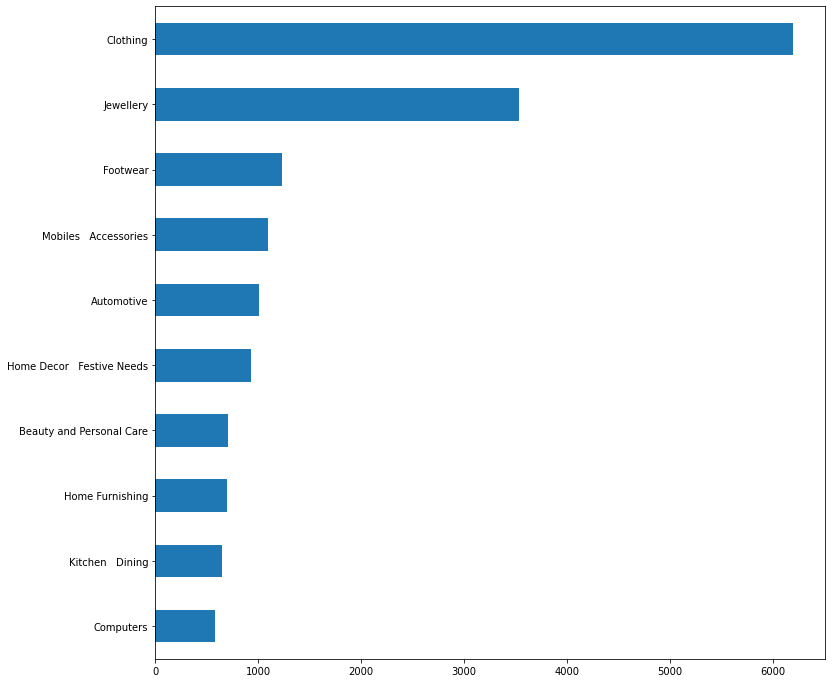

In [20]:
plt.figure(figsize=(12,12))
data1['category'].value_counts()[:10].sort_values().plot(kind ='barh')

Refining data by keeping rows corresponding to top 10 categories only

In [21]:
data1 = data1[data1['category'].isin(top_10)][['description', 'category']]
data1.head()

,description,category
0,Alisha Solid Women's Cycling Shorts Key Featur...,Clothing
2,AW Bellies Key Features of AW Bellies Sandals ...,Footwear
3,Alisha Solid Women's Cycling Shorts Key Featur...,Clothing
6,Alisha Solid Women's Cycling Shorts Key Featur...,Clothing
8,"dilli bazaaar Bellies, Corporate Casuals, Casu...",Footwear


Resetting index on row removal

In [22]:
data1 = data1.reset_index()

NLTK stopwords for further text preprocessing

In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

processed function accepts 'data' dataframe as input then operations are performed on description column. Everything accept alphabets are substituted with space using regex. Further sentences are made lower case and splitted on space to perform stemming operation. After stemming is done that took care of articles, verb forms, etc words are again joined and appended to a list 'corpus'

In [24]:
def processed(data):
  corpus = []
  stemming = PorterStemmer()
  for i in range(0, len(data)):
    print(i)
    remove = re.sub('[^a-zA-Z]', ' ', data['description'][i])
    partial = remove.lower()
    filter = partial.split()
    
    filter = [stemming.stem(word) for word in filter if not word in stopwords.words('english')]
    filter = ' '.join(filter)
    corpus.append(filter)
  return corpus

In [25]:
corpus = processed(data1)

Streaming output truncated to the last 5000 lines.
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
11677
11678
11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
11739
11740
11741
11742
11743
11744
11745
11746
11747
11748
11749
11750
11751
11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
11763
11764
11765
11766
11767
11768
11769
11770
11771
11772
11773
11774
11775
11776
11777
11778
11779
11780
11781
11782
11783
11784
11785
11786
1

In [26]:
len(corpus)

16629

data and labels are now splitted with 80:20 ratio for train:test dataset

In [27]:
x_train,x_test,y_train,y_test = train_test_split(corpus,data1.category.values,test_size=0.2,random_state = 42)
maxf = 5000
maxl = 250

In [28]:
x_train[0]

'statu first love women minim bra statu first love women minim bra price rs statu women non pad bra avail differ color full support statu women non pad bra avail differ color full support'

Features are further tokenized and text tokens are converted to matrices based on tfidf verctorisation that gives final training and testing features.

In [28]:
tokenizer = text.Tokenizer(num_words=maxf)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_matrix(x_train, mode = 'tfidf')

x_test = tokenizer.texts_to_matrix(x_test, mode = 'tfidf')


In [29]:
x_train.shape

(13303, 5000)

In [30]:
x_test.shape

(3326, 5000)

In [29]:
y_test

array(['Jewellery', 'Footwear', 'Footwear', ..., 'Footwear', 'Clothing',
       'Beauty and Personal Care'], dtype=object)

train and test labels are encoded to make then in categorical form from string

In [30]:
encoder = preprocessing.LabelEncoder()
y_train=encoder.fit_transform(y_train)
y_test=encoder.fit_transform(y_test)

further labels ae also binarized for multiclass auc score calculation and roc curve

In [31]:
y_testb = label_binarize(y_test, classes=[0, 1, 2,3,4,5,6,7,8,9])
y_trainb = label_binarize(y_train, classes=[0, 1, 2,3,4,5,6,7,8,9])

Multinomial Naive Bayes model is taken as NB models perform quiet well on text and sequential data and classification report is generated

In [108]:
clf=MultinomialNB()
clf.fit(x_train, y_train)
print(clf.score(x_train, y_train))
print (clf.score(x_test, y_test))
predicted_result=clf.predict(x_test)
print(classification_report(y_test,predicted_result))

0.9953393971284673
0.9846662657847264
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       220
           1       0.95      0.93      0.94       149
           2       1.00      1.00      1.00      1252
           3       0.89      0.96      0.92       112
           4       0.99      0.98      0.99       245
           5       0.95      0.97      0.96       186
           6       0.97      0.99      0.98       128
           7       1.00      1.00      1.00       671
           8       1.00      0.93      0.96       133
           9       0.97      0.96      0.96       230

    accuracy                           0.98      3326
   macro avg       0.97      0.97      0.97      3326
weighted avg       0.99      0.98      0.98      3326



Prediction on test data

In [109]:
y_pred = clf.predict_proba(x_test)

Multiclass Confusion matrix

In [70]:
cm = metrics.confusion_matrix(y_test, predicted_result)
cm

array([[ 216,    0,    0,    0,    0,    0,    0,    0,    0,    4],
       [   0,  139,    0,    3,    1,    4,    1,    1,    0,    0],
       [   0,    0, 1251,    0,    0,    0,    0,    1,    0,    0],
       [   0,    0,    0,  108,    1,    0,    0,    1,    0,    2],
       [   0,    1,    3,    0,  241,    0,    0,    0,    0,    0],
       [   0,    4,    0,    1,    0,  181,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    1,  127,    0,    0,    0],
       [   0,    1,    0,    1,    0,    1,    0,  668,    0,    0],
       [   1,    1,    0,    1,    0,    3,    3,    0,  124,    0],
       [   2,    0,    0,    8,    0,    0,    0,    0,    0,  220]])

test data accuracy score

In [71]:
accuracy_score(y_test,predicted_result)

0.9846662657847264

Now true positives and false positives along with auc score is calculated by iteration for all the 10 classes and is then micro-averaged to give an average fpr, tpr and roc area

In [111]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_testb[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_testb.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [112]:
roc_auc

{0: 0.9994892583269918,
 1: 0.994825433643237,
 2: 0.9995139888040273,
 3: 0.9914436838830119,
 4: 0.9986467420463803,
 5: 0.9967082734059312,
 6: 0.9993062070043778,
 7: 0.9988032590422143,
 8: 0.9866672632096998,
 9: 0.9983232221098752,
 'micro': 0.9979920547593962}

ROC is plotted along with corresponding area for all the 10 classes

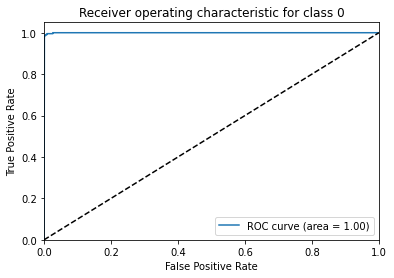

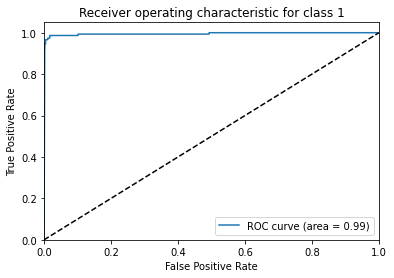

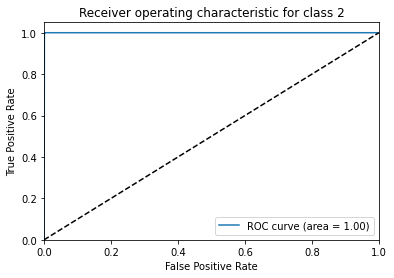

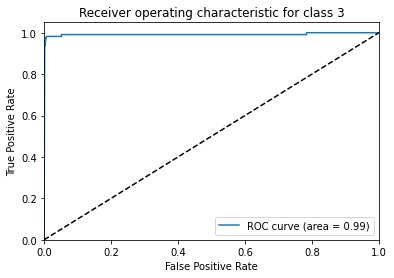

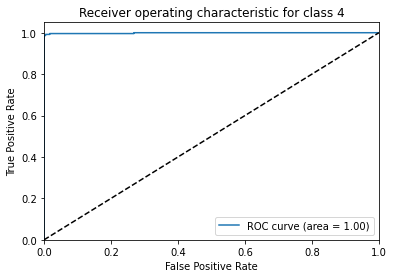

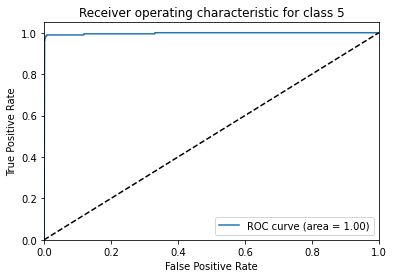

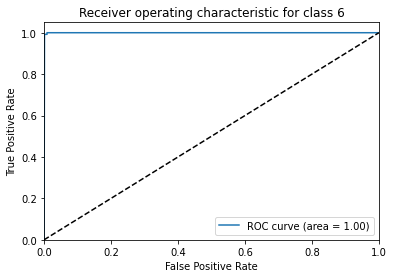

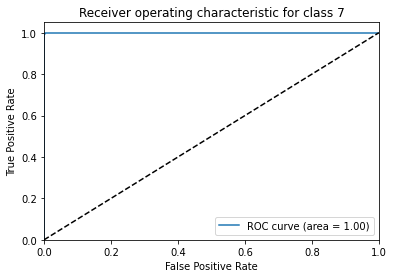

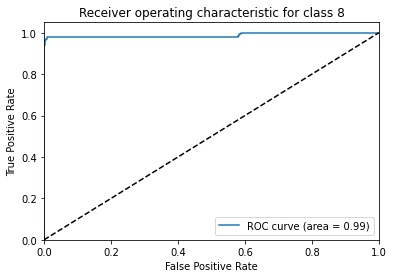

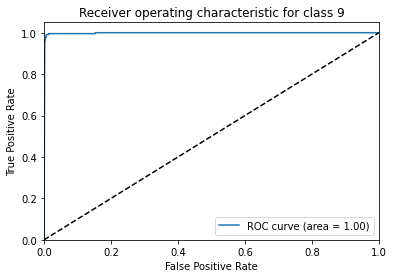

In [114]:
for i in range(10):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()

Dumping model in pickel file for future reuse

In [116]:
filename = 'NBClassifier.pkl'
pickle.dump(clf, open(filename, 'wb'))

A smaller version of pretrained Stanford glove embeddings are used and a dictionary is created with word and corresponding numeric value

In [32]:
glove_vec = dict()
file = open('Data/glove.twitter.27B.100d.txt', encoding='utf-8')
for line in file:
  values = line.split()
  word = values[0]
  vec = np.asarray(values[1:])
  glove_vec[word] = vec
file.close()

glove vec dictionary is now used for our tokenized data and an array of word embedding values is created for embedding layer of the model

In [35]:
voc_size = len(tokenizer.word_index)+1
word_vec_mat = np.zeros((voc_size,100))
for word, index in tokenizer.word_index.items():
  vector = glove_vec.get(word)
  if vector is not None:
    word_vec_mat[index] = vector
  else:
    print(word)

necklac
sleev
qualiti
bangl
jewelleri
coverag
warranti
allur
dimens
showpiec
vehicl
durabl
voylla
dailyobject
artifici
polyest
embroid
suitabl
speedwav
karatcraft
sturdi
wedg
preciou
ensur
slightli
thelostpuppi
wardrob
gemston
grafion
synthet
blous
adroitz
printland
closur
elast
oviyon
enhanc
diamet
blueston
camisol
kadhai
destudio
rockmantra
daili
sunshad
flexibl
deterg
portabl
clariti
textur
georgett
voltag
prithish
safeti
smartpro
nighti
jewelri
summari
puriti
microwav
placket
headphon
easili
antiqu
enthopia
customis
lifestyl
perfectli
dishwash
nimya
homeehub
essenti
painstakingli
exquisit
ploomz
contemporari
fragranc
theskinmantra
dressberri
geometr
funki
fadeproof
sapphir
vaniti
stretchabl
turtl
earphon
fuson
sparkl
breathabl
artificti
hotpip
lapguard
neckti
akup
friendli
deodor
authent
viviti
consumpt
sukkhi
adhes
wirefre
navaksha
nucod
vaishali
nexu
xebac
quantiti
manirathnum
younki
glossi
foldabl
massag
multifunct
fanci
oxyglow
getabhi
yepm
washabl
dangl
rotat
moistur
churidar


Data tokenisation for the LSTM classifier model

In [34]:
tokenizer = text.Tokenizer(num_words=maxf)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxl)
tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = sequence.pad_sequences(tokenized_test, maxlen=maxl)

Certain constants are initialised

In [37]:
batch_size = 24
epochs = 10
embed_size = 100

Keras sequential api is used to build model architecture with embedding layer, two lstm layers with one fully connected and output layer. Labels are used as binarized label format

In [38]:
model = Sequential()
model.add(Embedding(voc_size, output_dim=embed_size, weights=[word_vec_mat], input_length=maxl, trainable=False))

model.add(LSTM(units=100 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.3))
model.add(LSTM(units=50 , recurrent_dropout = 0.1 , dropout = 0.25))
model.add(Dense(units = 16 , activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          1161700   
_________________________________________________________________
lstm (LSTM)                  (None, 250, 100)          80400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
Total params: 1,273,286
Trainable params: 111,586
Non-trainable params: 1,161,700
________________________________________

Compiled model is fitted on the training data

In [39]:
product_cat = model.fit(x_train, y_trainb, batch_size=batch_size,
validation_data = (x_test,y_testb) , epochs = epochs)
model.save(lstmClassifier.h5)

Epoch 1/10
555/555 [==============================] - 862s 2s/step - loss: 1.1126 - accuracy: 0.6444 - val_loss: 0.6743 - val_accuracy: 0.7799
Epoch 2/10
555/555 [==============================] - 851s 2s/step - loss: 0.3939 - accuracy: 0.8790 - val_loss: 0.2142 - val_accuracy: 0.9393
Epoch 3/10
555/555 [==============================] - 858s 2s/step - loss: 0.1970 - accuracy: 0.9447 - val_loss: 0.1293 - val_accuracy: 0.9606
Epoch 4/10
555/555 [==============================] - 852s 2s/step - loss: 0.1612 - accuracy: 0.9539 - val_loss: 0.1550 - val_accuracy: 0.9603
Epoch 5/10
555/555 [==============================] - 856s 2s/step - loss: 0.1589 - accuracy: 0.9565 - val_loss: 0.1072 - val_accuracy: 0.9696
Epoch 6/10
555/555 [==============================] - 851s 2s/step - loss: 0.1198 - accuracy: 0.9677 - val_loss: 0.1147 - val_accuracy: 0.9726
Epoch 7/10
555/555 [==============================] - 854s 2s/step - loss: 0.1006 - accuracy: 0.9706 - val_loss: 0.0918 - val_accuracy: 0.9771

NameError: ignored

Model is saved for future reuse

In [40]:
model.save('lstmclassifier.h5')

Model performance on test data

In [42]:
model.evaluate(x_test,y_testb)

104/104 [==============================] - 11s 109ms/step - loss: 0.0915 - accuracy: 0.9793


[0.09152716398239136, 0.9792543649673462]

In [52]:
y_pred = model.predict_classes(x_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [55]:
y_proba = model.predict(x_test)

In [53]:
cm = metrics.confusion_matrix(y_test, y_pred)
cm

array([[ 216,    0,    1,    0,    0,    2,    1,    0,    0,    0],
       [   1,  139,    2,    0,    0,    2,    1,    2,    2,    0],
       [   0,    1, 1248,    0,    0,    0,    1,    2,    0,    0],
       [   1,    0,    0,  103,    0,    1,    0,    0,    0,    7],
       [   0,    1,    4,    1,  239,    0,    0,    0,    0,    0],
       [   0,    1,    0,    1,    0,  182,    0,    1,    1,    0],
       [   0,    0,    0,    0,    0,    2,  126,    0,    0,    0],
       [   0,    1,    0,    0,    0,    2,    5,  663,    0,    0],
       [   0,    1,    0,    0,    0,    3,    4,    0,  125,    0],
       [   3,    2,    0,    9,    0,    0,    0,    0,    0,  216]])

AUC score for multiclass predictions

In [56]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_testb[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_testb.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [57]:
roc_auc

{0: 0.9997424339987122,
 1: 0.9972157262877266,
 2: 0.9997165576543298,
 3: 0.9971608587429994,
 4: 0.9989627009518509,
 5: 0.9986165331141703,
 6: 0.9995382856472795,
 7: 0.9985428051001821,
 8: 0.9989450607414245,
 9: 0.9992290192113245,
 'micro': 0.999119474951528}

ROC curve for each class

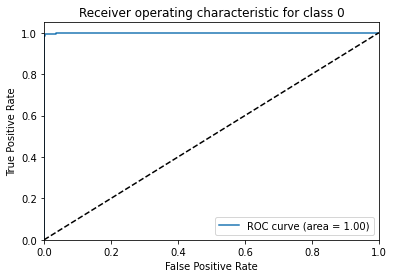

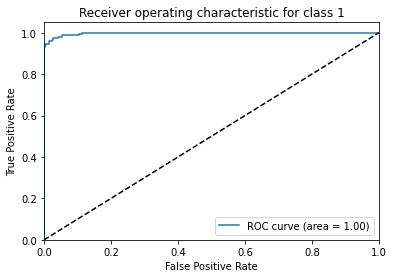

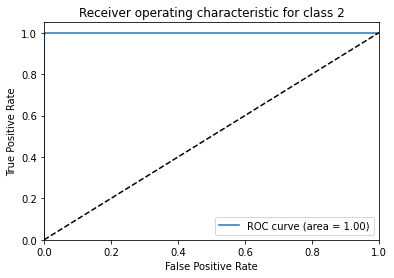

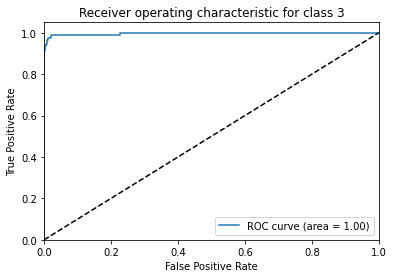

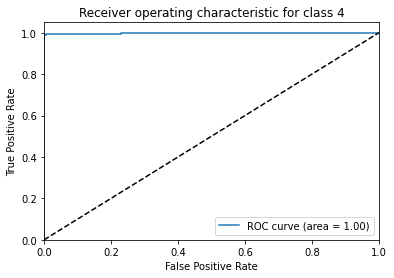

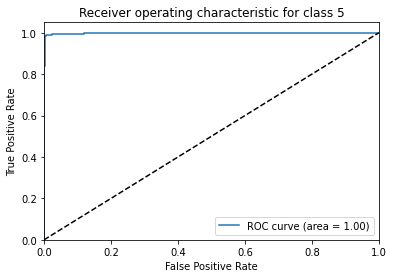

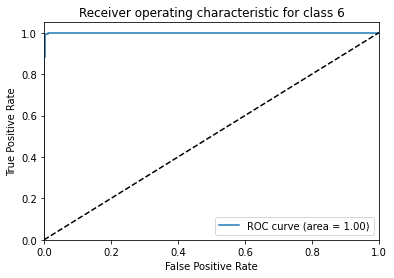

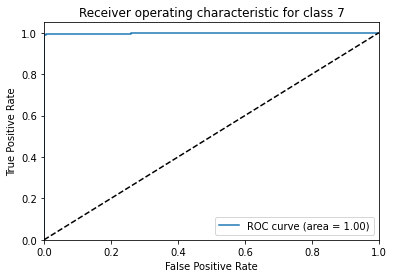

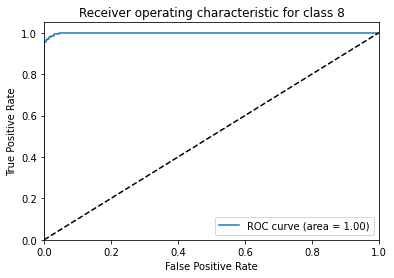

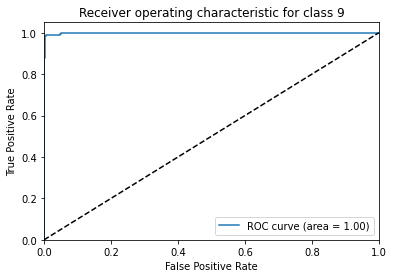

In [58]:
for i in range(10):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()